In [34]:
import pandas as pd
from scipy.spatial.distance import pdist
from unifrac import faith_pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from skbio.stats.ordination import pcoa
from skbio import TreeNode
from friendly_guacamole.datasets import DietInterventionStudy
from friendly_guacamole.transforms import Rarefaction, CLR, AsDense, UniFrac, \
    RarefactionBIOM, FaithPD
from q2_anomaly_detection.benchmark import Benchmark, ColumnValueSplitter, ExternalScorer
from q2_anomaly_detection.utils import as_dense, TrivialScorer
%matplotlib inline
from gemelli.rpca import rpca
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from skbio.diversity import alpha_diversity

from friendly_guacamole.datasets import Dataset, QiitaTable, QiitaMetadata, GreenGenes97Tree

In [2]:
class InfantTimeSeries(Dataset):

    study_id = 101
    table_artifact_id = 44767

    artifacts = {
        'table': QiitaTable(table_artifact_id),
        'metadata': QiitaMetadata(study_id),
        'tree': GreenGenes97Tree()
    }


In [3]:
RANDOM_SEED = 825
RAREFACTION_DEPTH = 1000

In [4]:
# qiita study 232 with trimming to 90 bp and pick closed reference on 97 otus tree
dataset = InfantTimeSeries('data/its')

Files already downloaded and verified


In [123]:
class RPCA(BaseEstimator):
    def __init__(self, n_components=2):
        self.n_components = n_components

    def fit(self, X, y=None):
        self.ordination, distances = rpca(X, n_components=self.n_components)
        self.embedding_ = self.ordination.samples
        return self
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.embedding_
    
    def transform(self, X):
        # TODO raise error
        pass

class AlphaDiversity(BaseEstimator, TransformerMixin):

    def __init__(self, metric):
        self.metric = metric

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return alpha_diversity(self.metric, X).values.reshape(-1, 1)

# TODO
# * extract diagonal
# * make sure biom table is sorted

class DiagonalExtraction(BaseEstimator, TransformerMixin):
    """
       s1 s2 s3 s4
    t1  0  1  2  3
    t2  4  5  6  7
    t3  8  9 10 11
    t4 12 13 14 15

    offset = -1
    start s1-t2 s2-t3 s3-t4
      pad     4     9    14

    offset = -2
    start1 start2 s1-t3 s2-t4
      pad     pad     8    13

    offset = 1
    t1-s2 t2-s3 t3-s4 end
        1     6    11 pad
    """

    def __init__(self, offset=0, pad_value=0):
        self.offset = offset
        self.pad_value = pad_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        n_samples = len(X)
        offset = self.offset
        start = max(0, -offset)
        end = min(n_samples, n_samples - offset)
        extracted_values = np.diagonal(X, offset=offset)

        if self.pad_value == 'mean':
            pad_value = extracted_values.mean()
        elif self.pad_value == 'first':
            pad_value = extracted_values[0]
        elif self.pad_value == 'last':
            pad_value = extracted_values[-1]
        else:
            pad_value = self.pad_value
        diag = np.full(n_samples, pad_value, dtype=float)
        diag[start:end] = extracted_values
        return diag.reshape(-1, 1)

In [127]:
a = pd.DataFrame(np.arange(16).reshape(4, 4))
d = DiagonalExtraction(offset=-1, pad_value='last')
d.fit_transform(a)


array([[14.],
       [ 4.],
       [ 9.],
       [14.]])

In [6]:
table = dataset['table']
tree = tree_path = dataset.apply('tree', 'path')

In [7]:
metadata_all = dataset['metadata']

In [8]:
metadata_all

,sample_name,age,age_unit,age_units,animation_gradient,animation_trajectory,anonymized_name,bmi,body_habitat,body_product,...,qiita_study_id,sample_type,scientific_name,sequencing_date,sex,solidfood,taxon_id,title,weight,weight_units
0,101.10,10,days,days,10,Child,sample006,Not applicable,UBERON:feces,UBERON:feces,...,101,stool,human gut metagenome,5/21/09,male,PRE,408170,Succession of microbial consortia in the devel...,Missing: Not provided,Missing: Not provided
1,101.100,100,days,days,100,Child,sample026,Not applicable,UBERON:feces,UBERON:feces,...,101,stool,human gut metagenome,5/21/09,male,PRE,408170,Succession of microbial consortia in the devel...,Missing: Not provided,Missing: Not provided
2,101.112,112,days,days,112,Child,sample027,Not applicable,UBERON:feces,UBERON:feces,...,101,stool,human gut metagenome,5/21/09,male,PRE,408170,Succession of microbial consortia in the devel...,Missing: Not provided,Missing: Not provided
3,101.118,118,days,days,118,Child,sample028,Not applicable,UBERON:feces,UBERON:feces,...,101,stool,human gut metagenome,5/21/09,male,PRE,408170,Succession of microbial consortia in the devel...,Missing: Not provided,Missing: Not provided
4,101.128,128,days,days,128,Child,sample029,Not applicable,UBERON:feces,UBERON:feces,...,101,stool,human gut metagenome,5/21/09,male,PRE,408170,Succession of microbial consortia in the devel...,Missing: Not provided,Missing: Not provided
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,101.85,85,days,days,85,Child,sample023,Not applicable,UBERON:feces,UBERON:feces,...,101,stool,human gut metagenome,2/8/10,male,PRE,408170,Succession of microbial consortia in the devel...,Missing: Not provided,Missing: Not provided
59,101.92,92,days,days,92,Child,sample024,Not applicable,UBERON:feces,UBERON:feces,...,101,stool,human gut metagenome,5/21/09,male,PRE,408170,Succession of microbial consortia in the devel...,Missing: Not provided,Missing: Not provided
60,101.98,98,days,days,98,Child,sample025,Not applicable,UBERON:feces,UBERON:feces,...,101,stool,human gut metagenome,5/21/09,male,PRE,408170,Succession of microbial consortia in the devel...,Missing: Not provided,Missing: Not provided
61,101.Meconium.16S,3,days,days,3,Child,sample001,Not applicable,UBERON:feces,UBERON:feces,...,101,stool,human gut metagenome,2/8/10,male,PRE,408170,Succession of microbial consortia in the devel...,Missing: Not provided,Missing: Not provided


In [9]:
def construct_category(metadata):
    pass


def subset_metadata(metadata_all, table):
    table_ids = set(table.ids())

    # also remove anything that does not have more than RAREFACTION_DEPTH counts
    #  in both 'Plant' and 'Meat'
    table_sum = table.sum(axis='sample')

    insufficient_count_ids = table.ids('sample')[table_sum < RAREFACTION_DEPTH]

    table_ids -= set(insufficient_count_ids)


    # metadata = metadata_all.query('host_common_name == "human" & sample_name in @table_ids &'
    #                               'diet in ["Plant", "Animal"]'
    #                              )
    #
    # diets_present = metadata[['host_subject_id', 'diet']].groupby('host_subject_id').agg(set)
    # diets_sufficient = diets_present.apply(lambda diets: diets >= {'Plant', 'Animal'})
    # sufficient_ids = diets_sufficient.loc[diets_sufficient['diet']].index

    sufficient_ids = table_ids
    
    metadata = metadata_all.query('sample_name in @sufficient_ids')
    metadata = metadata.query('host_subject_id == "Child"')

    return metadata

In [10]:
metadata = subset_metadata(metadata_all, table)

metadata = metadata.set_index('sample_name')

In [11]:
# TRAINING_CATEGORY = 'host_subject_id_for_plant'
# TRUTH_CATEGORY = 'host_subject_id'
# INTEREST_VARIABLE = 'diet'


TRAINING_CATEGORY = 'diet_for_subsample'
TRUTH_CATEGORY = 'diet'
INTEREST_VARIABLE = 'age'

In [12]:
metadata.columns

metadata.shape

(59, 50)

In [13]:
metadata[INTEREST_VARIABLE].unique()


array([ 10, 100, 112, 118, 128, 133, 134, 139,  14, 141, 146,  16, 161,
       168, 172, 173, 195, 202, 206,  23, 240, 244, 252, 265,  27, 273,
       280, 294, 297,  31,  33, 371,   4, 413, 432, 441, 454, 468, 469,
        48,   5, 539,  55,  57,  58,   6, 623,  63,  64,  70, 745,  77,
       831, 838,  84,  85,  92,  98,   3])

In [14]:
construct_category(metadata)

In [15]:
table.filter(metadata.index, axis='sample')

2137 x 59 <class 'biom.table.Table'> with 8572 nonzero entries (6% dense)

In [16]:
np.random.seed(RANDOM_SEED)
subtable = table  # table.subsample(RAREFACTION_DEPTH)
submetadata = metadata.loc[metadata.index.isin(subtable.ids('sample'))]

In [17]:
subtable.shape

(2137, 59)

In [18]:
study_ids = subtable.ids('sample')

In [19]:
# rarefied_table = Rarefaction(RAREFACTION_DEPTH).fit_transform(as_dense(subtable).astype(int))
# dm = pdist(rarefied_table, metric='jaccard')
# table_for_pcoa = CLR().fit_transform(as_dense(subtable))
# dm = pdist(table_for_pcoa, metric='euclidean')
dm = Pipeline(
    [
        ('rarefy', RarefactionBIOM(RAREFACTION_DEPTH)),
        ('unifrac', UniFrac(tree_path)),
    ]
).fit_transform(subtable)

pcoa_results = pcoa(dm)

pcoa_results.samples.index = study_ids

pcoa_with_metadata = pcoa_results.samples.join(metadata)



/home/garmstro/miniconda3/envs/q2-anomaly-detection/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-20-804b87d6b338>:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


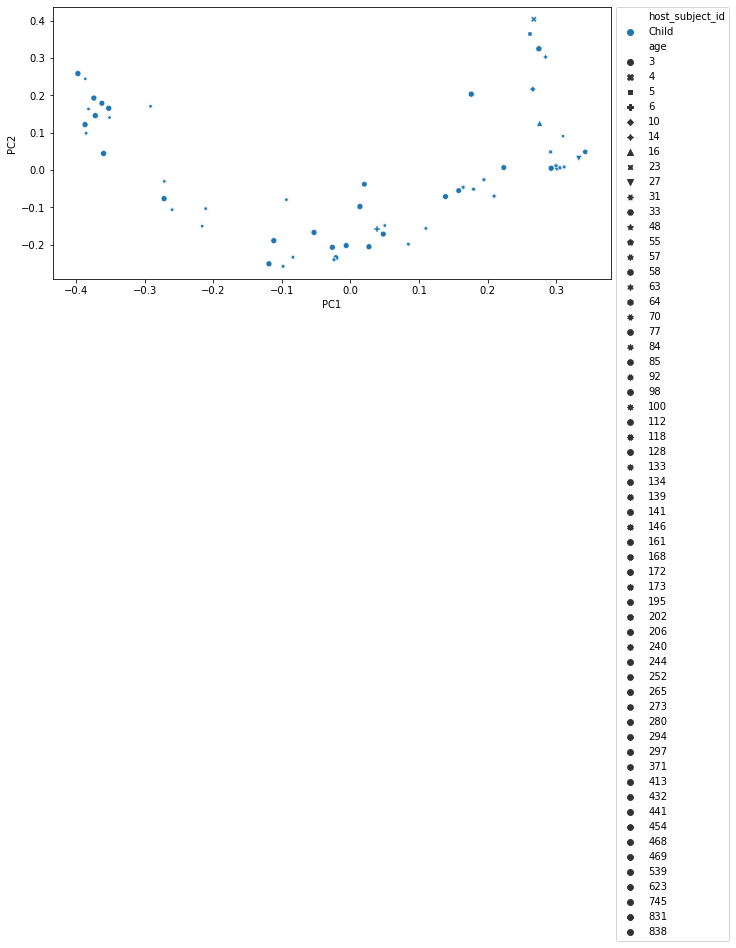

In [20]:
plt.subplots(figsize=(10, 5))
sns.scatterplot('PC1', 'PC2',
                hue='host_subject_id',
                style=INTEREST_VARIABLE,
                data=pcoa_with_metadata)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.tight_layout()

In [21]:
sns.set(font_scale=1.5)

In [22]:
from adtk.detector import (
    AutoregressionAD,
    InterQuartileRangeAD,
    ThresholdAD,
    GeneralizedESDTestAD,
    PersistAD,
)


In [23]:
# submetadata["time"] = pd.to_datetime(metadata.collection_date_publication.replace({"12.13/14.2011": "12.13.2011"}))

In [24]:
def format_params(d):
    strings = []
    for p, v in d.items():
        strings.append(f'{p}-{v}')
    return '--'.join(strings)

In [128]:
results = dict()

models = {
    'faiths_pd': {
        'model':
             Pipeline([
                ("rarefaction", RarefactionBIOM(RAREFACTION_DEPTH)) ,
                ("alpha", FaithPD(tree_path)),
            ]),
        'axis': "Faith's PD"
    },
    'unifrac': {
        'model':
             Pipeline([
                ("rarefaction", RarefactionBIOM(RAREFACTION_DEPTH)) ,
                ("unifrac", UniFrac(tree_path)),
                ("diag", DiagonalExtraction(offset=-1, pad_value='first')),
            ]),
        'axis': 'UniFrac with (t-1)',
    },
    'rpca': {
        'model':
            Pipeline([
                ("RPCA", RPCA()),
                ("select", ColumnTransformer(
                    [("PC", "passthrough", ["PC1", "PC2"])]
                ))
            ]),
        'axis': 'PC1',
    }
}

In [129]:
sample_id = "Child"
indivduals_ids = submetadata.loc[submetadata["host_subject_id"] == sample_id].index
individual_table = subtable.filter(indivduals_ids, inplace=False)
time_sorted = submetadata["age"].sort_values(ascending=True).index
subtable = subtable.sort_order(time_sorted)

/home/garmstro/miniconda3/envs/q2-anomaly-detection/lib/python3.8/site-packages/gemelli/preprocessing.py:155: RuntimeWarning: divide by zero encountered in log
  M_log = np.log(M_log.squeeze())
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


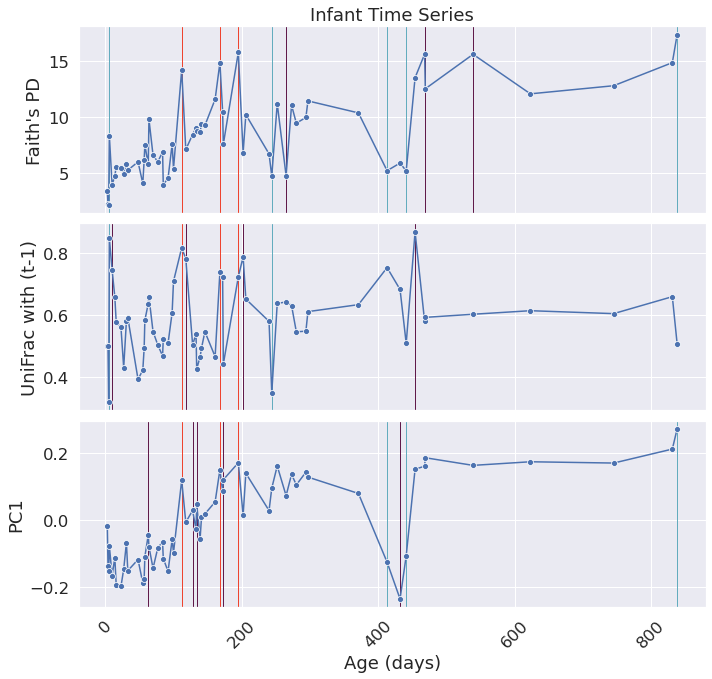

In [148]:
for i, (transform_name, transform_obj) in enumerate(models.items()):


    # P = pca.fit_transform(individual_table)
    transform = transform_obj['model']
    np.random.seed(724)
    P = transform.fit_transform(individual_table)

    # compute AD
    model_name = 'persist-ad'
    params = {
        'window': 10,
        'c': 0.5,
        'min_periods': 3
    }
    ad = PersistAD(**params)
    ad_series = pd.Series(
        P[:, 0] if not isinstance(P, pd.DataFrame) else P.iloc[:, 0].values,
        index=pd.to_datetime(submetadata.loc[individual_table.ids()]["age"]),
    )
    ad_series = ad_series.sort_index()
    anomalies = ad.fit_detect(ad_series)
    anomalies_x = anomalies.dropna().loc[anomalies.astype(bool)]
    anomalies_x = pd.to_numeric(anomalies_x.index)
    results[transform_name] = {
        'table': individual_table, 'anomalies': anomalies_x,
        'transformed_data': P, 'series': ad_series,
    }

fig, axs = plt.subplots(3, 1,
                        figsize=(10, 10),
                        sharex=True,
                        sharey=False,
                        )

anomaly_counts = dict()
anomaly_counts_cmap = {
    1: '#601a4a',
    2: '#63acbe',
    3: '#ee442f',
}
for i, (transform_name, transform_obj) in enumerate(models.items()):
    anomalies_x = results[transform_name]['anomalies']
    if anomalies_x.any():
        for anom in anomalies_x:
            if anomaly_counts.get(anom, 0):
                anomaly_counts[anom] += 1
            else:
                anomaly_counts[anom] = 1

for i, (transform_name, transform_obj) in enumerate(models.items()):
    individual_table = results[transform_name]['table']
    anomalies_x = results[transform_name]['anomalies']
    P = results[transform_name]['transformed_data']
    # plot AD
    v_pos = i // 3
    h_pos = i % 3
    g = axs[i]

    if anomalies_x.any():
        for anom in anomalies_x:
            c = anomaly_counts_cmap.get(anomaly_counts[anom], 'r')
            g.axvline(anom, 0, 1,
                      color=c,
                      linewidth=1,
                      alpha=1.0,
                      )

    g = sns.lineplot(
        x=pd.to_numeric(submetadata.loc[individual_table.ids()]["age"]),
        y=P[:, 0] if not isinstance(P, pd.DataFrame) else P.iloc[:, 0].values,
        ax=g,
        marker='o',
    )
    if (h_pos == 0):
        g.set_title('Infant Time Series')
    g.legend().remove()

    g.set_ylabel(transform_obj['axis'])
    g.set_xlabel('Age (days)')

    for tick in g.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
fig.subplots_adjust(bottom=0.15)
plt.savefig(f'results/infant-time-series--{model_name}--multi-transform'
            f'--{format_params(params)}.png', dpi=300)